In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

In [10]:
# Finding the number of images in each dataset
test_path = os.path.normpath('dataset/MapAI/512x512_task1_test/image')
no_test_images = len([name for name in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, name))])

# Defining size of images
IMG_HEIGHT = 512
IMG_WIDTH = 512

# Creating NumPy arrays for the different subsets
X_test = np.zeros((no_test_images, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
Y_test = np.zeros((no_test_images, IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

# Adding images to NumPy arrays
img_path = os.path.normpath('dataset/MapAI/512x512_task1_test/image')
mask_path = os.path.normpath('dataset/MapAI/512x512_task1_test/mask')
count = 0
with os.scandir(img_path) as entries:
    for n, entry in enumerate(entries):
        img = cv.imread(os.path.normpath(img_path + '/' + entry.name))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        X_test[n] = img
        mask = cv.imread(os.path.normpath(mask_path + '/' + entry.name))
        mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
        Y_test[n] = mask
        count += 1
        if count == 10:
            break

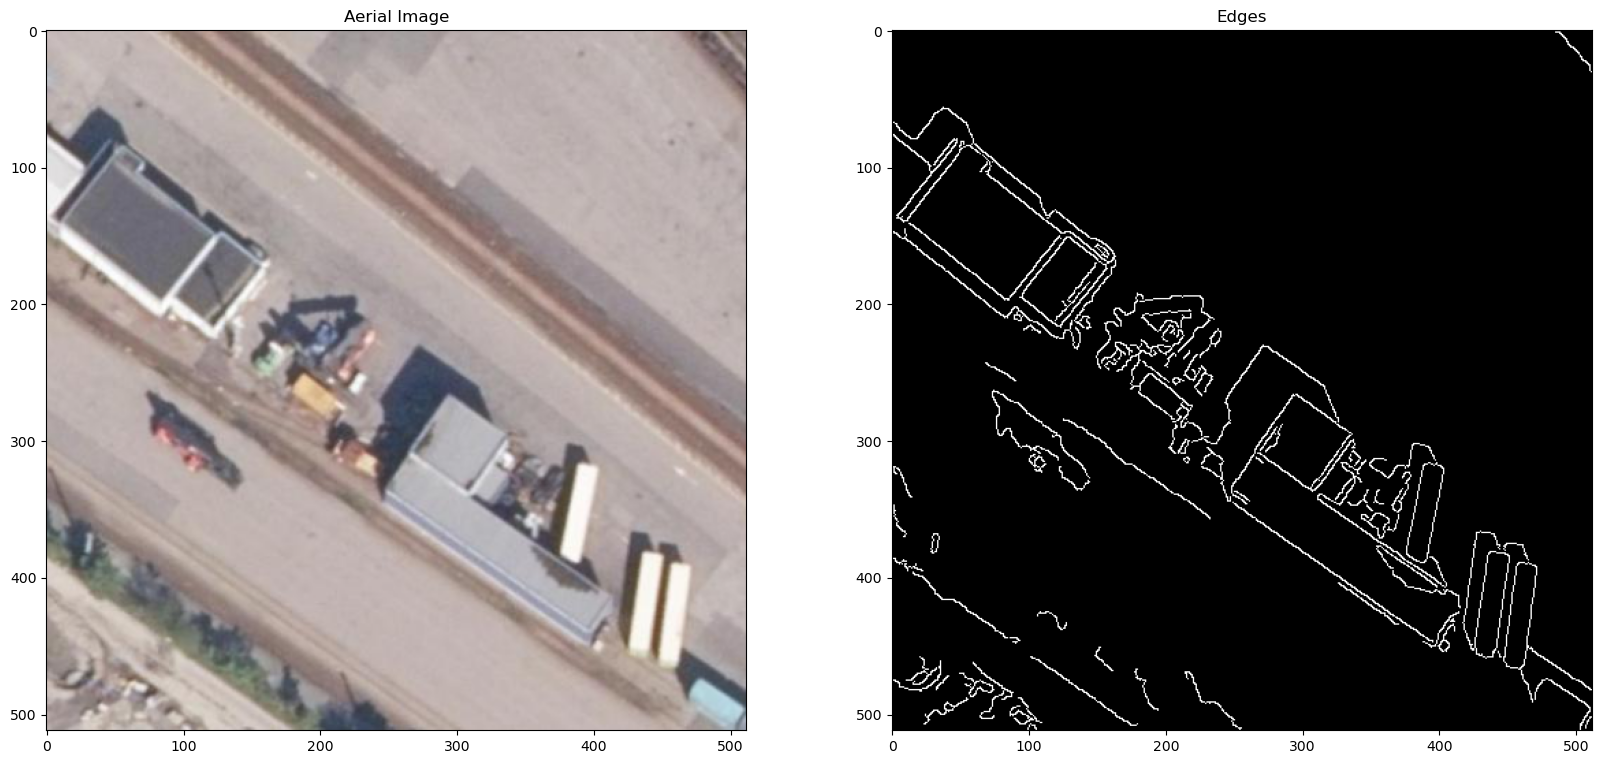

In [95]:
index = 4
lower_thresh = 100
upper_thresh = 220

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('Aerial Image')
plt.imshow(X_test[index])
plt.subplot(222)
plt.title('Edges')
canny = cv.Canny(X_test[index], upper_thresh, lower_thresh)
plt.imshow(canny, cmap='gray')
plt.show()